**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [33]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

import matplotlib.image as img
import glob 

In [34]:
#utility function to fetch the image path+names for cars and non cars respectively.
def get_image_names():
    non_vehicles1=np.array(glob.glob('TrainingData/non-vehicles/non-vehicles/Extras/ex*.png'))
    non_vehicles2=np.array(glob.glob('TrainingData/non-vehicles/non-vehicles/GTI/im*.png'))
    non_vehicles=np.append(non_vehicles1,non_vehicles2)
    vehicles=np.array(glob.glob('TrainingData/vehicles/vehicles/*/*.png'))
    return non_vehicles,vehicles

### Visualizing Training Data
So in the training set we have *8968 Non Vehicle Images* and *8792 vehicle Images*

In [35]:

data=get_image_names()
print('non_vehicle images=',len(data[0]),'and vehhile images=',len(data[1]))

non_vehicle images= 8968 and vehhile images= 8792


In [36]:
def load_images():
    non_vehicle,vehicle=get_image_names()
    cars=[]
    non_cars=[]
    for name in vehicle:
        cars.append(cv2.imread(name))
    for name in non_vehicle:
        non_cars.append(cv2.imread(name))
    return cars,non_cars

### Training Data Shape
Each training image has 64x64x3 shape.

In [37]:
cars,non_cars=load_images()
print(cars[0].shape)

(64, 64, 3)


#### Visualizing Images
Below is an example of Car and Non Car Image

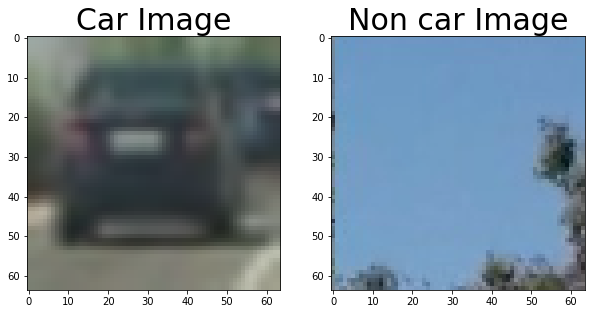

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(cv2.cvtColor(cars[0],cv2.COLOR_BGR2RGB))
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(cv2.cvtColor(non_cars[0],cv2.COLOR_BGR2RGB))
ax2.set_title('Non car Image', fontsize=30)

## HOG Features
To detect the vehicles I used Histogram of Oriented Gradients as one of the feature. I took HOG on the 'YCrCb' color space and to be more specific I used 'Cr' color channel to extract HOG features. I tried different color spaces and different color channels while going through the classroom quizes, however while trying different combinations and found that the classifier accuracy is best if I use color channel 'Cr' for the hog features. 

Function below takes image and color space name as input, orientation and other parameters are optional. However during the training I used ``pix_per_cell=16`` 
``orient=9`` ``Color_space=YCrCb`` ``cells_per_block=2`` and ``Channel=1``

I used this configurations because I realized that the accuracy of classifier is above 95% if I am feeding it data, taken out of hog with this configuration. The feature vector length is *576* if I use this configuration.

In [39]:
from skimage.feature import hog
def get_hog_features(image,cspace, orient=9, pix_per_cell=8, cell_per_block=2, vis=True,
                     feature_vec=True,channel=0):
    if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            elif cspace == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else: feature_image = np.copy(image)
    return_list = hog(feature_image[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

### Output of HOG 
Below is the example of HOG output

shape of hog features  (324,)


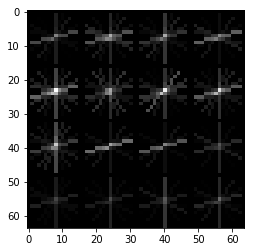

In [40]:
hog_features,hog_image=get_hog_features(cars[1],'YCrCb',channel=1,pix_per_cell=16)
print('shape of hog features ',hog_features.shape)

plt.imshow(hog_image,cmap='gray')

## Spatial Binning
I used Spatial Binning to extract more features from the image. So in Spatial Binning we take the raw pixel values from the image. The basic concept here is; in images, even if we decrease the size of the image within certain range, it still retains most of its information. 

So here input image was 64x64 image which I resized as 16x16 image and then I used it as feature vector for the classifier along with HOG feature vector.
I used ``ravel()`` function to convert the 2D array to vector.

I used 'YUV' color space for spatial binning, the below function takes the image input and convert it to the given Color space. After few observations it was clear 'YUV' gives good result in our case, this can be seen in the sample outputs below:

In [41]:
def bin_spatial(image, cspace='BGR', size=(16, 16)):
    # Convert image to new color space (if specified)
    if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            elif cspace == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else: feature_image = np.copy(image)
    # Use cv2.resize().ravel() to create the feature vector
    small_img=cv2.resize(feature_image,size) # Remove this line!
    # Return the feature vector
    features=small_img.ravel()
    return features

#### Spatial Binning output for Car Images

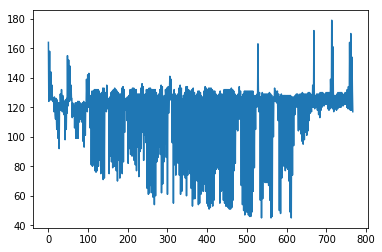

In [43]:
plt.plot(bin_spatial(cars[0],'YUV'))

#### Spatial Binning output for Non Car Images

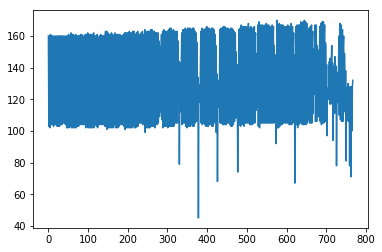

In [44]:
plt.plot(bin_spatial(non_cars[0],'YUV'))

## Color Histogram
I also used Color Histograms to fetch features out of an image. As the name implies we take an image and based on the given color channel and bin size specifications we calculate the histogram for each given channel and bin size and then append them together to form a feature vector. 

I used HLS color space and 'S' color channel for the color histogram feature vector. After doing some experimentaion I found that Saturation can be a reliable feature to identify the Vehicles.

I used ``Number of bins=32`` ``color space=HLS`` and ``bins range=0-256``

Below is the sample output of color histogram for a given image and given color space(HLS in our case).

In [45]:
def color_hist(image, nbins=32, channel=None,bins_range=(0, 256),cspace='BGR',v=False):
    # Compute the histogram of the RGB channels separately
    if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            elif cspace == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else: feature_image = np.copy(image)
    if(channel==None):
        first_hist = np.histogram(feature_image[:,:,0],bins=nbins,range=bins_range)
        second_hist = np.histogram(feature_image[:,:,1],bins=nbins,range=bins_range)
        third_hist = np.histogram(feature_image[:,:,2],bins=nbins,range=bins_range)
        bin_edges=first_hist[1]
    
        bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
        if(v):
            return first_hist, second_hist, third_hist,bin_centers
        else:
            hist_features = np.concatenate((first_hist[0], second_hist[0], third_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
            return hist_features
    else:
        first_hist = np.histogram(feature_image[:,:,channel],bins=nbins,range=bins_range)
    bin_edges=first_hist[1]
    # Generating bin centers
    bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
   # hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if(v):
        return first_hist,bin_centers
    return first_hist[0]

#### Output of Color Histogram function

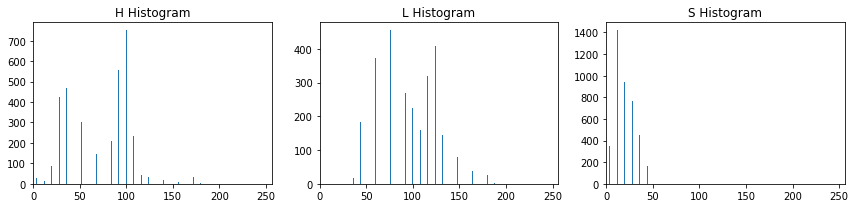

In [46]:
histogram=color_hist(cars[0],cspace='HLS',v=True)
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(histogram[3], histogram[0][0])
plt.xlim(0, 256)
plt.title('H Histogram')
plt.subplot(132)
plt.bar(histogram[3], histogram[1][0])
plt.xlim(0, 256)
plt.title('L Histogram')
plt.subplot(133)
plt.bar(histogram[3], histogram[2][0])
plt.xlim(0, 256)
plt.title('S Histogram')
fig.tight_layout()

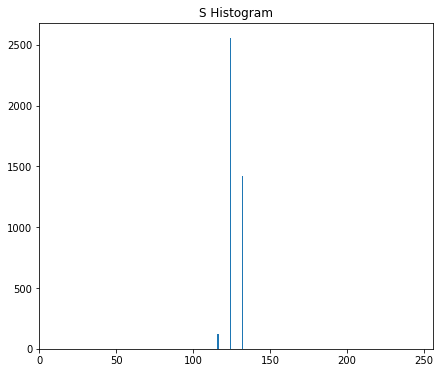

In [47]:
histogram=color_hist(cars[0],cspace='YUV',channel=1,v=True)
fig = plt.figure(figsize=(24,6))
plt.subplot(131)
plt.bar(histogram[1], histogram[0][0])
plt.xlim(0, 256)
plt.title('S Histogram')

## Classifier
I used Support Vector Machine as my classifier, I choose this because it has simple implementaion and training time for this classifier is also considerably small while compared with Neural Networks and other classifiers. 

Initially I was using 'linear' kernel, but even after acheiving 96% test accuracy with the linear kernel there were too many false postive detections. Then I thought of increasing the size of feature vector or to use Radial Basis function('rbf') as kernel. However I used 'rbf' kernel since it gave 99% test accuracy and the number of false positive detection also decreased drastically. 

In [48]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def train_model(X_train,y_train):
    svc=SVC(kernel='rbf')
    svc.fit(X_train,y_train)
    return svc
    

## Extract Features
Function ``extract_fetures()`` is used to fetch feature vector from each image during the training phase of the classifier. This function simply extracts the feature vector for each image and it dumps these features into a pickle file, later we use these features to traing our classifier.

In [49]:
import pickle
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
def extract_features():
    cars,non_cars=load_images()
    cars_features=[]
    non_cars_features=[]
    for car in cars:
        color_hist_features1=color_hist(car,cspace='HLS',channel=2)
        #color_hist_features2=color_hist(car,cspace='YUV',channel=1)
        hog_features=get_hog_features(car,'YCrCb',channel=1,pix_per_cell=16)[0]
        spatial_features=bin_spatial(car,'YUV')
        temp=np.array([])
        temp=np.append(temp,color_hist_features1)
        #temp=np.append(temp,color_hist_features2)
        temp=np.append(temp,hog_features)
        temp=np.append(temp,spatial_features)
        cars_features.append(temp)
    
    for non_car in non_cars:
        color_hist_features1=color_hist(non_car,cspace='HLS',channel=2)
        #color_hist_features2=color_hist(non_car,cspace='YUV',channel=1)
        hog_features=get_hog_features(non_car,'YCrCb',channel=1,pix_per_cell=16)[0]
        spatial_features=bin_spatial(non_car,'YUV')
        temp=np.array([])
        temp=np.append(temp,color_hist_features1)
        #temp=np.append(temp,color_hist_features2)
        temp=np.append(temp,hog_features)
        temp=np.append(temp,spatial_features)
        non_cars_features.append(temp)
    
    file=open('data.pkl','wb')
    obj1=['cars',cars_features]
    obj2=['non_cars',non_cars_features]
    pickle.dump(obj1, file)
    pickle.dump(obj2, file)
    file.close()   

## Train Model and save 
Function ``train_and_save()`` uses the features received from function ``extract_features`` to train the classifier and later it save it to a pickle file.

I have used ``StandardScaler()`` to scale all the features in the feature vector for all the images, it is important since if there is so much variation among the values of the features then there are chances that the classifier gets biased towards the higher value features. I had to save the scaler once I fetch it, since same scaler shall be used to make predictions which was used to scale the input during the training.

Length of the feature vector is 1124

In [51]:
def train_and_save(flag_extract_features=False):
    if(flag_extract_features):
        extract_features()
    pickle_in = open("data.pkl","rb")
    example_dict = pickle.load(pickle_in)
    cars_features=example_dict[1]
    example_dict = pickle.load(pickle_in)
    non_cars_features=example_dict[1]
    pickle_in.close()
    print('Length of feature vector=',cars_features[0].shape[0])
    X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
    
# Define the labels vector
    y = np.hstack((np.ones(len(cars_features)), np.zeros(len(non_cars_features))))

# Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


    X_scaler = StandardScaler().fit(X_train)

    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    t=time.time()
    clf=train_model(X_train,y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    file=open('classifier.pkl','wb')
    obj1=['model',clf]
    obj2=['scaler',X_scaler]
    pickle.dump(obj1,file)
    pickle.dump(obj2,file)
    file.close()
    return clf,X_scaler

In [52]:
train_and_save()

Length of feature vector= 1124
41.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

## Sliding Window
Once I was done training the classifier, next challenge was how to find the vehicles in a given image. Well, I used sliding window approach to find vehices in an image. In this we use different sized windows and move them accross the image, fetch feature vector for that window and feed those features to our trained classifier, if classifier predicts that Yes! it is a vehicle then mark that window. 

It was challenging to fit the good window size for the sliding window, after experimenting different combinations for the sliding window size I finally used two window sizes:
1. 50x50 window for y=400 to y=500 since near the horizon the cars will be far and small in size, in this case overlap is 50% for both x and y.
2. 80x100 window for y=500 to y=650 since in this region cars will appear larger in size, in this case overlap is 70% for both x and y.

I have used different sized windows because vehicles in differnt regions of the image appears different, i.e. vehicles near the car appears bigger and far from the car appears smaller. I tried different overlaping factors, use of small overlaping factor worked well, if the window size is small too, for large windows overlaping factor should also be large. I realized the overlaping factor also depends on what threshold you use during the heatmap implementaion. 

In [53]:
def slide_window(img,window_list, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(100, 70), xy_overlap=(0.8, 0.8)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list 

In [54]:
def search_windows(image, windows, clf,scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        test_features=[]
        color_hist_features1=color_hist(test_img,cspace='HLS',channel=2)
        #color_hist_features2=color_hist(test_img,cspace='YUV',channel=1)
        hog_features=get_hog_features(test_img,'YCrCb',channel=1,pix_per_cell=16)[0]
        spatial_features=bin_spatial(test_img,'YUV')
        
        temp=np.array([])
        temp=np.append(temp,color_hist_features1)
        #temp=np.append(temp,color_hist_features2)
        temp=np.append(temp,hog_features)
        temp=np.append(temp,spatial_features)
        test_features.append(temp)
        #print(test_features)
        #5) Scale extracted features to be fed to classifier
        #scaler=StandardScaler().fit(test_features)
        features = scaler.transform(np.array(test_features).reshape(1, -1))
        #print(features)
        #6) Predict using your classifier
        prediction = clf.predict(features)
        #7) If positive (prediction == 1) then save the window
        #print(prediction)
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [55]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Heatmap 
Since window size is small, hence our classfier predicts 1(Vehicle) for most of the windows that contain some part of the vehicle in it because of this for a vehicle we have different windows marked. But at last we want to show only one bounding box for a vehicle. To overcome this problem we use heatmap. 

``add_heat`` function is used to find out which part of image was considered how many times by the classifier that this part has a vehicle. i.e. if the value of a pixel is 10 it means that pixel was included 10 times in such windows for which the prediction was 1.

Once we have a heatmap now we can apply thresholding to it so that we have only those regions that have higher probabilities that there is a vehicle in the region.

#### Label 
Label the obtained detection areas with the ``label()`` function of the scipy.ndimage.measurements package. In this step we outline the boundaries of labels that is, we label each cluster of windows as one car, so in this step we simply get the bounding box of that cluster(vehicle).

#### False Positive Filtering
To filter false positives I ignored all the windows which has dimensions smaller than 30x30, using this I was able to filter out most of the false positives in my output.

In [56]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # False Positve Filtering
        if((np.absolute(bbox[0][0]-bbox[1][0])>30) & ( np.absolute(bbox[0][1]-bbox[1][1])>30)):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    return img


#### Output after using heatmap

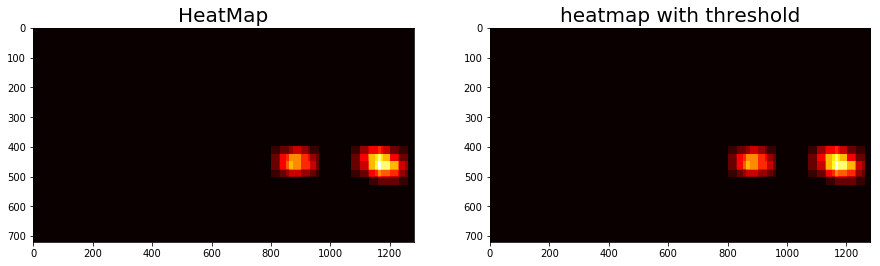

In [57]:
test_imagee=cv2.imread('./test_images/test1.jpg')
windows=[]
windows=slide_window(test_imagee,windows,x_start_stop=[200, None], y_start_stop=[400, 500],xy_window=(50,50),xy_overlap=(0.5,0.5))
windows=slide_window(test_imagee,windows,x_start_stop=[200, None], y_start_stop=[400, 656],xy_window=(100,80),xy_overlap=(0.7,0.7))
#windows=slide_window(test_imagee,windows,x_start_stop=[200, None], y_start_stop=[500, 650],xy_window=(128,128),xy_overlap=(0.6,0.6))
pickle_input = open("classifier.pkl","rb")
example_dict = pickle.load(pickle_input)
clf1=example_dict[1]
example_dict = pickle.load(pickle_input)
scaler1=example_dict[1]
#clf,scaler=train_and_save()
pickle_input.close()
on_windows=search_windows(test_imagee, windows, clf1,scaler1)
heat=np.zeros_like(test_imagee[:,:,0]).astype(np.float)
heatmap=add_heat(heat,on_windows)
th=apply_threshold(heatmap,0.7)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(heatmap,cmap='hot')
ax1.set_title('HeatMap', fontsize=20)
ax2.imshow(th,cmap='hot')

ax2.set_title('heatmap with threshold', fontsize=20)

## Pipeline

I have used a class named ``vehicle_detection`` to keep data from the previous frames. A vehicle will not move more than few pixels in any direction hence we can use data collected from previous frames so that there is small variation in the window size in consecutive frames.

The pipeline performs few steps during execution:
1. It takes an image as an input and converts it from RGB to BGR color space.
2. It calls `slide_window()` function to get different windows.
3. It loads the trained classifier and scaler from the pickle file.
4. It calls `search_window()` and provides image and windows from step 2 to the function, this function fetches features for that window and feeds them to classifier to get the predicted value.
5. It calls the heatmap fucntion to get only a bounding box for each image in an image.
6. It keeps the running average of the heatmap values for previous 18 frames, later I used the mean of those values.
9. Draw the bounding box and return the image

In [58]:
class vehicle_detection:
    heatmap_average=np.array([])
    def pipeline(self,image):
        windows=[]
        image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        windows=slide_window(test_imagee,windows,x_start_stop=[200, None], y_start_stop=[400, 500],xy_window=(50,50),xy_overlap=(0.5,0.5))
        windows=slide_window(test_imagee,windows,x_start_stop=[200, None], y_start_stop=[400, 656],xy_window=(100,80),xy_overlap=(0.7,0.7))

        pickle_in = open("classifier.pkl","rb")
        example_dict = pickle.load(pickle_in)
        clf=example_dict[1]
        example_dict = pickle.load(pickle_in)
        scaler=example_dict[1]
        #clf,scaler=train_and_save()
        pickle_in.close()
        on_windows=search_windows(image, windows, clf,scaler)
        #output=draw_boxes(image,on_windows)
        heat=np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap=add_heat(heat,on_windows)
        self.heatmap_average=np.append(self.heatmap_average,heatmap)
        if(len(self.heatmap_average)>18*len(np.array(heatmap).ravel())):
            self.heatmap_average=self.heatmap_average[len(np.array(heatmap).ravel()):]
        #print(len(self.heatmap_average),len(np.array(heatmap).ravel()))
        heatmap=np.mean((self.heatmap_average.reshape(-1,len(np.array(heatmap).ravel()))),axis=0)
        heatmap=heatmap.reshape(-1,image.shape[1])
        #print(heatmap.shape)
        heatmap=apply_threshold(heatmap,0.7)
        labels = label(heatmap)
        output = draw_labeled_bboxes(np.copy(image), labels)
        return cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

#### FInal Output for one frame

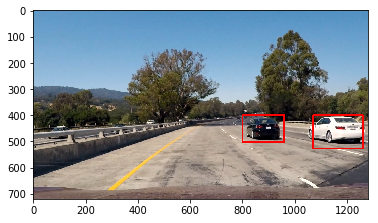

In [60]:
test_imagee=img.imread('./test_images/test1.jpg')
detection=vehicle_detection()
plt.imshow(detection.pipeline(test_imagee))

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_Submission_final.mp4'
detection=vehicle_detection()
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detection.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_Submission_final.mp4
[MoviePy] Writing video project_video_Submission_final.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:07:25<00:03,  3.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_Submission_final.mp4 

Wall time: 1h 7min 27s


## Challenges
I faced following challenges while working on the project.
1. First challenge was to choose what features to use, it took a lot of experimentation to select the appropriate features.
2. Second was which classifier should I use, I chose SVM as classifier and 'linear' as my kernel but even after achieving 95% of test accuracy with linear kernel lots of false postive detections were made. I later used 'rbf' kernel to overcome the problem of false detection.
3. What size of windows should I choose was the most challenging part, It took lots of effort and testing to come up with the window size that would work fine for our problem. I chose different sized windows for vehicle detection.
4. After detection bounding boxes were wobbling too much frame to frame, to overcome this I tried keeping a running average of heatmap from previous frames. It worked out really well for this problem.